In [2]:
# autoreload
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline
import scipy.io

import numpy as np
import matplotlib.pyplot as plt
import mne 
import pprint
from tqdm import tqdm
import pickle

import mne_features
import antropy
import EntropyHub
import time

In [4]:
from utils.data import iterate_all, get_feature_shape
from utils.data import Dataset
dataset: Dataset = Dataset.get_dataset(reload=False)

In [5]:
human_params = pickle.load(open('human_params.pkl', 'rb'))
pprint.pprint(human_params)

{1: (array([-0.05394619, -0.04388971, -0.01177887, -0.09346739, -0.05006357,
       -0.12824975, -0.03793747, -0.04504644, -0.08138568, -0.11476885,
       -0.07845486,  0.01753703,  0.01127064,  0.00850268, -0.13765219,
       -0.26076092, -0.02897663, -0.07655146, -0.04385711, -0.06137678,
       -0.05067507, -0.00313189, -0.11405991,  0.00952971, -0.3029063 ,
       -0.09924799, -0.02951463, -0.06997363, -0.03897163, -0.02561061,
       -0.29612538, -0.23540298, -0.1498701 , -0.13698046, -0.15682182,
       -0.01309064, -0.03997104, -0.03668645, -0.12134676, -0.26826032,
       -0.25750544, -0.17279104, -0.14537714, -0.04758733, -0.01017709,
        0.00166914,  0.01101147, -0.14257193, -0.14433904, -0.14332313,
       -0.10125199, -0.10064796, -0.09080673,  0.03730345, -0.03083767,
       -0.0547343 , -0.10315241, -0.02766299, -0.07964948,  0.0027448 ,
       -0.0097675 ,  0.00075083]),
     array([271.0994111 , 269.78378117, 269.75481978, 269.59895998,
       269.31527274, 276.666

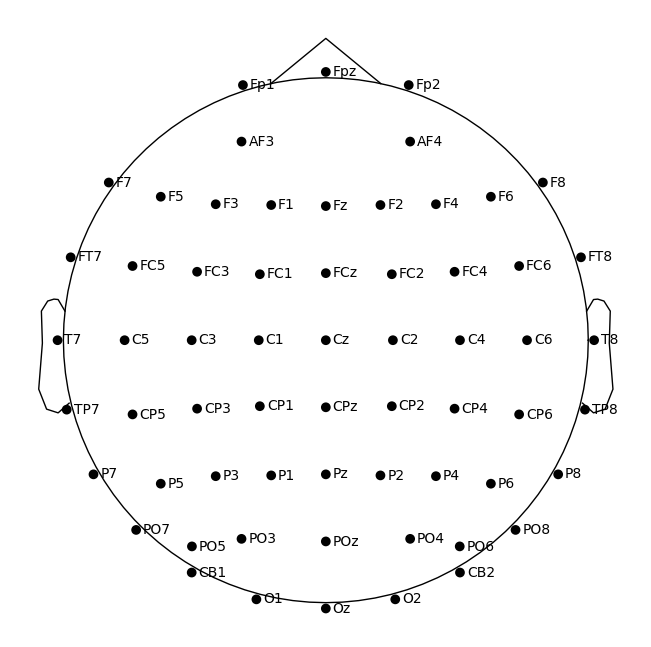

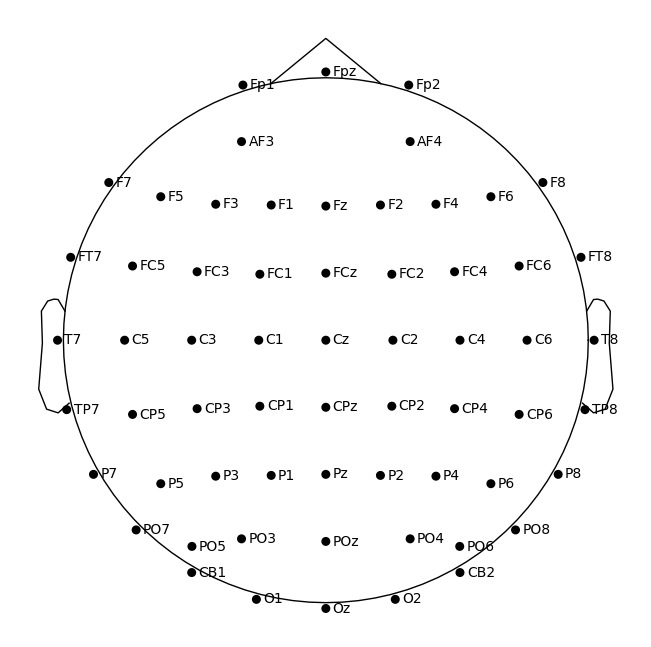

In [6]:
montage = mne.channels.read_custom_montage(r'SEED-IV/channel_62_pos.locs')
mne.viz.plot_montage(montage)

In [7]:
def convert_np2mne(data: np.ndarray):
    n_channels = 62
    sampling_freq = 200  # in Hertz
    info = mne.create_info(n_channels, sfreq=sampling_freq)
    ch_names = ["Fp1", "Fpz", "Fp2", "AF3", "AF4", "F7", "F5", "F3", "F1", "Fz", "F2", "F4", "F6", "F8", "FT7", "FC5", "FC3", "FC1", "FCz", "FC2", "FC4", "FC6", "FT8", "T7", "C5", "C3", "C1", "Cz", "C2", "C4", "C6", "T8", "TP7", "CP5", "CP3", "CP1", "CPz", "CP2", "CP4", "CP6", "TP8", "P7", "P5", "P3", "P1", "Pz", "P2", "P4", "P6", "P8", "PO7", "PO5", "PO3", "POz", "PO4", "PO6", "PO8", "CB1", "O1", "Oz", "O2", "CB2"]
    ch_types = ["eeg"]*62
    info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq)
    eeg = mne.io.RawArray(data/1e6, info)
    eeg.set_montage(montage)
    return eeg

In [8]:
def eeg_filter(mne_data, low_freq, high_freq):
    return mne_data.copy().filter(low_freq, high_freq, 'eeg')

In [9]:
def split_abgd(eeg_data):
    eeg_alfa = eeg_data.copy().filter(8, 15, 'eeg')
    eeg_beta = eeg_data.copy().filter(16, 31, 'eeg')
    eeg_gamma = eeg_data.copy().filter(32, 45, 'eeg')
    eeg_teta = eeg_data.copy().filter(4, 7, 'eeg')
    return eeg_alfa, eeg_beta, eeg_gamma, eeg_teta


In [10]:
import scipy.signal

Fs = 200
def peak2peak(channel):
    poz_pik, mag_pik = mne.preprocessing.peak_finder(channel) #90
    Ts = 1/Fs
    prvo = Ts*poz_pik[1:]
    drugo = Ts*poz_pik[0:-1]
    razlika = prvo - drugo
    PTP = np.mean(razlika)
    return PTP

# Ovo treba proveriti
def calculate_c0(x):
    X = np.fft.fft(x, axis=-1)
    M = np.mean(np.abs(X)**2, axis=-1)
    Y = np.where(X > M, X, 0)
    y = np.fft.ifft(Y, axis=-1)
    A1 = np.sum((x - y)**2, axis=-1)
    A0 = np.sum(x**2, axis=-1)
    return A1 / A0

In [11]:
# min_time = min(data.shape[1] for data, label, ids in iterate_all(dataset)) / Fs
# min_time = min_time // 5 * 5 # da se zaokruzi na lepe brojeve

In [12]:
# sreca - strah, tuga
# sreca, strah - tuga
# neutral - svaka

# 5 fold cross validation

# box plotovi za feature-e

In [13]:
min_time = 40 # OVo treba proveriti

In [14]:
def get_features_from_mne(eeg_band):
    eeg_band_data = eeg_band.get_data()
    var = eeg_band_data.var(axis=-1)
    msv = np.mean((eeg_band_data**2), axis=-1)
    hjorth_mobility = mne_features.univariate.compute_hjorth_mobility(eeg_band_data)
    hjorth_complexity = mne_features.univariate.compute_hjorth_complexity(eeg_band_data)
    p2p = np.apply_along_axis(peak2peak, 1, eeg_band_data)
    aprox_entropy = np.apply_along_axis(antropy.app_entropy, 1, eeg_band_data)
    c0 = np.apply_along_axis(calculate_c0, 1, eeg_band_data)
    svd_entropy = mne_features.univariate.compute_svd_entropy(eeg_band_data)
    spectral_entropy = mne_features.univariate.compute_spect_entropy(Fs, eeg_band_data)
    permutation_entropy = np.apply_along_axis(antropy.perm_entropy, 1, eeg_band_data, normalize=True)
    # Ovo nesto zeza vraca dva broja ali ne znam sta su
    # kolmogorov_entropy = np.apply_along_axis(lambda x: EntropyHub.K2En(x)[0], 1, eeg_band_data)
    feature_list = [var, msv, hjorth_mobility, hjorth_complexity, p2p, aprox_entropy, c0, svd_entropy, spectral_entropy, permutation_entropy]
    return np.stack(feature_list, axis=-1)
    

In [16]:

# Treba razmisliiti da li ima smisla da za svaki band pravimo posebne feature
# pod band_id mislim na alpha, beta, gamma, delta
# (session_id, human_id, video_id, epoch_id, band_id, channel_id, feature_id)
# (3, 15, 24, 8, 4, 62, 10)
features = np.zeros(get_feature_shape(dataset))
# Obratiti paznju da je session_id, human_id, video_id mislim da krecu od 1 a ne od 0 ali treba proveriti
# Takodje za pocetak mozda samo izdvojiti 


mne.set_log_level("WARNING")
progress_bar = tqdm(enumerate(iterate_all(dataset)), total=3*15*24)
for i, (data, label, ids) in enumerate(iterate_all(dataset)):
    progress_bar.set_description(f"Processing (session_id, human_id, video_id) {str(ids)}")
    session_id, human_id, video_id = ids
    data -= human_params[human_id][0][:, None] # proveriti da li treba po sessiji  ili sve zajendo
    data /= human_params[human_id][1][:, None]
    mne_data = convert_np2mne(data)
    mne_filtered_data = eeg_filter(mne_data, low_freq=0.5, high_freq=50)
    # get only first 5 seconds

    for i in range(0, min_time, 5):
        epoch_id = i // 5
        print(f"Processing {i} - {i+5} seconds")
        mne_crop_data = mne_filtered_data.copy()
        mne_crop_data = mne_crop_data.crop(tmin=i, tmax=i+5)
        for band_id, eeg_band in enumerate(split_abgd(mne_crop_data)):
            features[session_id-1, human_id-1, video_id-1, epoch_id, band_id] = get_features_from_mne(eeg_band)
    
    break

In [ ]:
import concurrent.futures

# ...

features = np.zeros(get_feature_shape(dataset))

mne.set_log_level("WARNING")

def process_data(i, data, label, ids):
    session_id, human_id, video_id = ids
    data -= human_params[human_id][0][:, None]
    data /= human_params[human_id][1][:, None]
    mne_data = convert_np2mne(data)
    mne_filtered_data = eeg_filter(mne_data, low_freq=0.5, high_freq=50)

    for i in range(15, min_time, 5):
        epoch_id = i // 5
        # print(f"Processing {i} - {i+5} seconds")
        mne_crop_data = mne_filtered_data.copy()
        mne_crop_data = mne_crop_data.crop(tmin=i, tmax=i+5)
        for band_id, eeg_band in enumerate(split_abgd(mne_crop_data)):
            features[session_id-1, human_id-1, video_id-1, epoch_id, band_id] = get_features_from_mne(eeg_band)
        break
    print(f"finished {i}")
    return i

with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
    results = [executor.submit(process_data, i, data, label, ids) for i, (data, label, ids) in enumerate(iterate_all(dataset))]

for result in concurrent.futures.as_completed(results):
    i = result.result()
    

    # Handle the result if needed
    print(i)


In [4]:
!pip install azure-ai-ml
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

ml_client = MLClient.from_config(credential=DefaultAzureCredential())
data_asset = ml_client.data.get("SEED-IV", version="1")
from azureml.fsspec import AzureMachineLearningFileSystem
fs = AzureMachineLearningFileSystem(data_asset.path)
fs.ls()

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try 'pacman -S
    python-xyz', where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Arch-packaged Python package,
    create a virtual environment using 'python -m venv path/to/venv'.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip.
    
    If you wish to install a non-Arch packaged Python application,
    it may be easiest to use 'pipx install xyz', which will manage a
    virtual environment for you. Make sure you have python-pipx
    installed via pacman.

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Python installation or OS, by passing --break-system-packages.
hint: See PEP 668 for the detailed specification.


ModuleNotFoundError: No module named 'azure'